In [9]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import re
import nltk
nltk.download('stopwords') #make sure list up to date
from nltk.corpus import wordnet
from IPython.display import clear_output
from scipy import stats

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\magar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#read in scraped data
chartsDf = pd.read_csv('charts_and_lyrics_2013-2017.csv', encoding='utf-8')

chartsDf.head(10)

,year,chart,chartURL,rank,song,artist,lyrics
0,2013,Hot100,https://www.billboard.com/charts/year-end//201...,1,Thrift Shop,Macklemore & Ryan Lewis Featuring Wanz,"[Intro]\n""Hey, Macklemore, can we go thrift sh..."
1,2013,Hot100,https://www.billboard.com/charts/year-end//201...,2,Blurred Lines,Robin Thicke Featuring T.I. + Pharrell,[Intro: Pharrell & Robin Thicke]\nEverybody ge...
2,2013,Hot100,https://www.billboard.com/charts/year-end//201...,3,Radioactive,Imagine Dragons,[Intro]\nWhoah-oh\nWhoah-oh\nWhoah-oh\nWhoah\n...
3,2013,Hot100,https://www.billboard.com/charts/year-end//201...,4,Harlem Shake,Baauer,"[Pre-Chorus]\nCon los terroristas, -tas, -tas,..."
4,2013,Hot100,https://www.billboard.com/charts/year-end//201...,5,Can't Hold Us,Macklemore & Ryan Lewis Featuring Ray Dalton,"[Intro: Macklemore]\nAy, ay, ay\nGood to see y..."
5,2013,Hot100,https://www.billboard.com/charts/year-end//201...,6,Mirrors,Justin Timberlake,[Verse 1]\nAren't you somethin' to admire\n'Ca...
6,2013,Hot100,https://www.billboard.com/charts/year-end//201...,7,Just Give Me A Reason,P!nk Featuring Nate Ruess,[Verse 1: P!nk]\nRight from the start\nYou wer...
7,2013,Hot100,https://www.billboard.com/charts/year-end//201...,8,When I Was Your Man,Bruno Mars,[Verse 1]\nSame bed but it feels just a little...
8,2013,Hot100,https://www.billboard.com/charts/year-end//201...,9,Cruise,Florida Georgia Line Featuring Nelly,[Intro]\nBaby you a song\nYou make me wanna ro...
9,2013,Hot100,https://www.billboard.com/charts/year-end//201...,10,Roar,Katy Perry,[Video Directed by Grady Hall & Mark Kudsi]\n\...


# Get Lemmas and Drop Stopwords from Lyrics

- Lemmas are root words eg 'studies' and 'studying' would both become 'study'. Plurals and different tenses of a word will be reduced to the same root so it will help avoid splitting the counts of words over variants with the same meaning.
- Stopwords are highly frequent words with little meaning like 'is', 'at', 'I'. Removing them to, again, help improve any counting done later on.

In [11]:
def lineSplitAndClean(lyrics): 
    '''return the lyrics split into lines and stripped of punctuation characters'''
    
    #make sure lyrics were found for this song
    #lyrics will be np.nan if none were found
    if not pd.isnull(lyrics):
        #strip "[Chorus]", "[Verse 1]" etc tags
        lyrics = re.sub(r'\[.*\]', '', lyrics)
        
        #splitting on \n instead of using sent_tokenize() from nltk as I don't
        #expect song lyrics to have great sentence structure so think \n will
        #be a more reliable delimiter
        #using .lower both for uniformity and cause stopwords list is all lowercase
        lines = [line.lower() for line in lyrics.split('\n') if len(line)>0]
        
        #strip any punctuation
        lines = [re.sub(r'\W',' ',line) for line in lines]

        #replace any multiple consecutive spaces with just one space
        lines = [re.sub(r'\s+',' ',line) for line in lines]
        
        #possible for lines to be an empty list here like for instrumental
        #songs the starting lyrics will just be '[instrumental]'
        if lines:
            return lines
        
    return np.nan

In [12]:
#breaking lyrics into lines so nltk.pos_tag get's sentences passed to it rather 
#than all the words at once. Should give better context for tagging.
chartsDf['lines'] = chartsDf.lyrics.apply(lineSplitAndClean)

chartsDf.head(10)

,year,chart,chartURL,rank,song,artist,lyrics,lines
0,2013,Hot100,https://www.billboard.com/charts/year-end//201...,1,Thrift Shop,Macklemore & Ryan Lewis Featuring Wanz,"[Intro]\n""Hey, Macklemore, can we go thrift sh...","[ hey macklemore can we go thrift shopping , w..."
1,2013,Hot100,https://www.billboard.com/charts/year-end//201...,2,Blurred Lines,Robin Thicke Featuring T.I. + Pharrell,[Intro: Pharrell & Robin Thicke]\nEverybody ge...,"[everybody get up woo , hey hey hey, hey hey h..."
2,2013,Hot100,https://www.billboard.com/charts/year-end//201...,3,Radioactive,Imagine Dragons,[Intro]\nWhoah-oh\nWhoah-oh\nWhoah-oh\nWhoah\n...,"[whoah oh, whoah oh, whoah oh, whoah, i m waki..."
3,2013,Hot100,https://www.billboard.com/charts/year-end//201...,4,Harlem Shake,Baauer,"[Pre-Chorus]\nCon los terroristas, -tas, -tas,...","[con los terroristas tas tas tas, tas tas tas..."
4,2013,Hot100,https://www.billboard.com/charts/year-end//201...,5,Can't Hold Us,Macklemore & Ryan Lewis Featuring Ray Dalton,"[Intro: Macklemore]\nAy, ay, ay\nGood to see y...","[ay ay ay, good to see you come on let s go, y..."
5,2013,Hot100,https://www.billboard.com/charts/year-end//201...,6,Mirrors,Justin Timberlake,[Verse 1]\nAren't you somethin' to admire\n'Ca...,"[aren t you somethin to admire, cause your sh..."
6,2013,Hot100,https://www.billboard.com/charts/year-end//201...,7,Just Give Me A Reason,P!nk Featuring Nate Ruess,[Verse 1: P!nk]\nRight from the start\nYou wer...,"[right from the start, you were a thief you st..."
7,2013,Hot100,https://www.billboard.com/charts/year-end//201...,8,When I Was Your Man,Bruno Mars,[Verse 1]\nSame bed but it feels just a little...,[same bed but it feels just a little bit bigge...
8,2013,Hot100,https://www.billboard.com/charts/year-end//201...,9,Cruise,Florida Georgia Line Featuring Nelly,[Intro]\nBaby you a song\nYou make me wanna ro...,"[baby you a song, you make me wanna roll my wi..."
9,2013,Hot100,https://www.billboard.com/charts/year-end//201...,10,Roar,Katy Perry,[Video Directed by Grady Hall & Mark Kudsi]\n\...,"[i used to bite my tongue and hold my breath, ..."


In [13]:
def convertPOSTag(treebank_tag):
    '''
    Return equivilent wordnet word type tag for a given treebank tag.
    
    nltk.pos_tag() uses tags from the treebank corpus 
    https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html    
    but the lemmatiser uses tags from word net so need to convert.
    Only noun, verb, adjective and adverb are accepted.
    Adapted from https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
    '''
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ #returns 'a'
    elif treebank_tag.startswith('V'):
        return wordnet.VERB #returns 'v'
    elif treebank_tag.startswith('R'):
        return wordnet.ADV #returns 'r'

    #return noun for both actual nouns and anything that doesn't fit the other three 
    #noun is the default for the lemmatiser anyway so this will have same effect 
    #as not passing a tag.
    else:
        return wordnet.NOUN #returns 'n'

In [14]:
#needed corrections found by looking at 2017 top 25 of noun, verb, adj and adverb dfs

#high ranking slang words I noticed that aren't getting their correct lemmas
lemmaCorrections = {'wan':'want', #from wanna
                    'gon':'go', #from gonna, gon.
                    'lil':'little',
                    'hol':'hold' #from "hol' up" from LOVE. by Kendrick Lamar
                   }

stopwords = nltk.corpus.stopwords.words('english') #are lowercase
nltkStopwordsWithAdditions = stopwords + \
                             ['la', #comes up a lot (like 'la-la-la') but isn't a word so don't include it
                              'eh', 'ayy', #same as 'la'. 'eh' as in pronounced like 'aye'
                              'oh', 'ooh', #an exclamation with no real meaning but ranks highly so exclude
                              'us', 'u', 'ya', #different forms of 'you' which is a stopword
                              'na', 'ta', #alt forms of 'to' which is a stopword. From 'gonna', 'wanna', 'gotta'
                              'nah', #usage a mix of a sung-only word and slang for 'no' which is a stopword
                              'po', 'woo', 'doo', 'ah', 'uh', 'uhh' #sung-only words
                             ]

In [15]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def getLemmasAndWordTags(lines):
    '''
    return a list of tuples of (lemma, word type tag) for each word
    in the passed lines
    '''
    
    #make sure lyrics were found for this song
    #lyrics will be np.nan if none were found
    try:
        if pd.isnull(lines): #causes an ValueError when lines is an array (eg [[x], [y]])
            return
    except ValueError:
        pass
    
    lemmasAndWordTagsList = []
    for line in lines:
        words = nltk.word_tokenize(line)

        #gives list of tuples in form [(car, NN), (run, VB)... etc]
        word_tags = nltk.pos_tag(words)

        #add lemmas and words to count list
        for wordAndTag in word_tags:
            word = wordAndTag[0]
            tag = convertPOSTag(wordAndTag[1])
            
            if word not in nltkStopwordsWithAdditions: 
                lemma = lemmatizer.lemmatize(word, tag)
                
                #correct known misclassified lemmas
                if lemma in lemmaCorrections.keys():
                    lemma = lemmaCorrections[lemma]
                
                lemmaAndTag = (lemma, tag)
                lemmasAndWordTagsList.append(lemmaAndTag)

                #keep a list of words that are feeding into this lemma for sanity checking
                if lemmaAndTag not in lemmaSourceWords.keys():
                    lemmaSourceWords[lemmaAndTag] = []
                    
                if word not in lemmaSourceWords[lemmaAndTag]:
                    lemmaSourceWords[lemmaAndTag].append(word)
    
    if lemmasAndWordTagsList:
        return lemmasAndWordTagsList
    else:
        return np.nan

In [16]:
lemmaSourceWords = {} #will be populated by getLemmasAndWordTags function
chartsDf['lemmasAndTags'] = chartsDf.lines.apply(getLemmasAndWordTags)
chartsDf.head(10)

,year,chart,chartURL,rank,song,artist,lyrics,lines,lemmasAndTags
0,2013,Hot100,https://www.billboard.com/charts/year-end//201...,1,Thrift Shop,Macklemore & Ryan Lewis Featuring Wanz,"[Intro]\n""Hey, Macklemore, can we go thrift sh...","[ hey macklemore can we go thrift shopping , w...","[(hey, n), (macklemore, r), (go, v), (thrift, ..."
1,2013,Hot100,https://www.billboard.com/charts/year-end//201...,2,Blurred Lines,Robin Thicke Featuring T.I. + Pharrell,[Intro: Pharrell & Robin Thicke]\nEverybody ge...,"[everybody get up woo , hey hey hey, hey hey h...","[(everybody, n), (get, v), (hey, n), (hey, n),..."
2,2013,Hot100,https://www.billboard.com/charts/year-end//201...,3,Radioactive,Imagine Dragons,[Intro]\nWhoah-oh\nWhoah-oh\nWhoah-oh\nWhoah\n...,"[whoah oh, whoah oh, whoah oh, whoah, i m waki...","[(whoah, n), (whoah, n), (whoah, n), (whoah, n..."
3,2013,Hot100,https://www.billboard.com/charts/year-end//201...,4,Harlem Shake,Baauer,"[Pre-Chorus]\nCon los terroristas, -tas, -tas,...","[con los terroristas tas tas tas, tas tas tas...","[(con, n), (los, n), (terroristas, a), (ta, n)..."
4,2013,Hot100,https://www.billboard.com/charts/year-end//201...,5,Can't Hold Us,Macklemore & Ryan Lewis Featuring Ray Dalton,"[Intro: Macklemore]\nAy, ay, ay\nGood to see y...","[ay ay ay, good to see you come on let s go, y...","[(ay, n), (ay, n), (ay, n), (good, a), (see, v..."
5,2013,Hot100,https://www.billboard.com/charts/year-end//201...,6,Mirrors,Justin Timberlake,[Verse 1]\nAren't you somethin' to admire\n'Ca...,"[aren t you somethin to admire, cause your sh...","[(somethin, v), (admire, v), (cause, v), (shin..."
6,2013,Hot100,https://www.billboard.com/charts/year-end//201...,7,Just Give Me A Reason,P!nk Featuring Nate Ruess,[Verse 1: P!nk]\nRight from the start\nYou wer...,"[right from the start, you were a thief you st...","[(right, r), (start, n), (thief, n), (steal, v..."
7,2013,Hot100,https://www.billboard.com/charts/year-end//201...,8,When I Was Your Man,Bruno Mars,[Verse 1]\nSame bed but it feels just a little...,[same bed but it feels just a little bit bigge...,"[(bed, n), (feel, v), (little, a), (bit, n), (..."
8,2013,Hot100,https://www.billboard.com/charts/year-end//201...,9,Cruise,Florida Georgia Line Featuring Nelly,[Intro]\nBaby you a song\nYou make me wanna ro...,"[baby you a song, you make me wanna roll my wi...","[(baby, n), (song, n), (make, v), (want, v), (..."
9,2013,Hot100,https://www.billboard.com/charts/year-end//201...,10,Roar,Katy Perry,[Video Directed by Grady Hall & Mark Kudsi]\n\...,"[i used to bite my tongue and hold my breath, ...","[(use, v), (bite, v), (tongue, n), (hold, v), ..."


# Investigate Prevalence of Drinking Words

I've created a list of all the drinking related words I could think of. Looking at how many times they appear and in what percentage of songs.

All songs that mention these words may not be using them in the alcoholic sense, eg. "I'm drunk in love". However if a song is using that analagy then it must expect its audience to be familar with drinking. So I think it's fair to include all occurances of these words.

Excluding 'drink' and 'shot' from the list for not being specific enough to drinking alcohol. Was particuarly an issue with the Christian chart where those two words were causing 8 false positives out of 11. 

In [71]:
drinkingKeywords = [#'drink', #causing a relatively high percentage of false positives in the Christian chart 
                    #'shot', #not including as not specific enough to just drinking
                    'drunk', #will only get occurances that are not the past tense verb of 'drink' due to lemmatisation
                    'drank', #will only get occurances that are not the past tense verb of 'drink' due to lemmatisation
                    'alcohol',
                    'alcoholic',
                    'hangover',
                    'hungover',
                    'liquor',
                    'cocktail',
                    'booze',
                    'boozy',
                    'bottle',
                    'beer',
                    'cider',
                    'ale',
                    'tequila',
                    'vodka',
                    'wine',
                    'gin',
                    'whiskey',
                    'scotch',
                    'rum',
                    'bourbon',
                    'champagne',
                    'mojito',
                    'martini',
                    'daiquiri',
                    'jager',
                    'jagermeister',
                    'budweiser',
                    'miller',
                    'coors',
                    'heineken',
                    'bacardi',
                    'smirnoff',
                    'moet',
                    'hennesey',
                    'bar',
                    'pint',
                    'firewater',
                    'hootch',
                    'moonshine',
                    'spirits',
                    'swig',
                    'tipple']

print('Amount of keywords:', len(drinkingKeywords))

Amount of keywords: 44


In [72]:
drinkingWordsCounter = dict(zip(drinkingKeywords, [0]*len(drinkingKeywords)))

In [73]:
def countDrinkWords(lemmasAndTags):
    try:
        if pd.isnull(lemmasAndTags): #causes an ValueError when lines is an array (eg [[x], [y]])
            return np.nan
    except ValueError:
        pass
    
    wordCount = 0
    for lemmaAndTag in lemmasAndTags:
        #lemmaAndTag is tuple in form (lemma, tag) so first item is the lemma
        if lemmaAndTag[0] in drinkingKeywords:
            wordCount += 1
            drinkingWordsCounter[lemmaAndTag[0]] +=1
    return wordCount

In [74]:
chartsDf['drinkingWordsCount'] = chartsDf.lemmasAndTags.apply(countDrinkWords)
chartsDf['hasDrinkingWords'] = chartsDf.drinkingWordsCount >0

chartsDf.to_csv('charts_drinking_words_counts.csv', 
                index=False, 
                encoding='utf-8')

drinkingWordsCounter

{'alcohol': 24,
 'alcoholic': 1,
 'ale': 1,
 'bacardi': 16,
 'bar': 176,
 'beer': 101,
 'booze': 1,
 'boozy': 0,
 'bottle': 209,
 'bourbon': 4,
 'budweiser': 0,
 'champagne': 68,
 'cider': 0,
 'cocktail': 0,
 'coors': 0,
 'daiquiri': 0,
 'drank': 137,
 'drunk': 189,
 'firewater': 0,
 'gin': 17,
 'hangover': 161,
 'heineken': 0,
 'hennesey': 0,
 'hootch': 0,
 'hungover': 7,
 'jager': 0,
 'jagermeister': 0,
 'liquor': 65,
 'martini': 0,
 'miller': 2,
 'moet': 5,
 'mojito': 0,
 'moonshine': 11,
 'pint': 6,
 'rum': 22,
 'scotch': 1,
 'smirnoff': 0,
 'spirits': 0,
 'swig': 2,
 'tequila': 13,
 'tipple': 0,
 'vodka': 9,
 'whiskey': 170,
 'wine': 143}

In [75]:
entriesFound = chartsDf.groupby(['chart', 'year']).chart.count()
entriesFound.name = 'chartEntriesFound'

lyricsFoundCount = chartsDf.groupby(['chart', 'year']).lyrics.count()
lyricsFoundCount.name = 'lyricsFound'

containDrinkingWords = chartsDf.groupby(['chart', 'year']).hasDrinkingWords.sum()
containDrinkingWords.name = 'songsContainingDrinkingWords'

percentageOfSongsWithDrinking = (chartsDf.groupby(['chart', 'year']).hasDrinkingWords.sum() /
                                 chartsDf.groupby(['chart', 'year']).song.count())
percentageOfSongsWithDrinking.name = 'percentageOfSongsWithDrinking'

drinkingSongsSummary = pd.concat([entriesFound, 
                                  lyricsFoundCount, 
                                  containDrinkingWords,
                                  percentageOfSongsWithDrinking], 
                                 axis=1)

drinkingSongsSummary.to_csv('charts_drinking_words_counts_summary.csv', 
                            index=True, 
                            encoding='utf-8')

### Percentage Songs Mentioning Drinking by Chart

chart
Christian           0.003096
Country             0.406122
Dance/Electronic    0.095768
Hot100              0.182773
Pop                 0.141667
R&B/Hip-Hop         0.284960
Rock                0.093168
dtype: float64


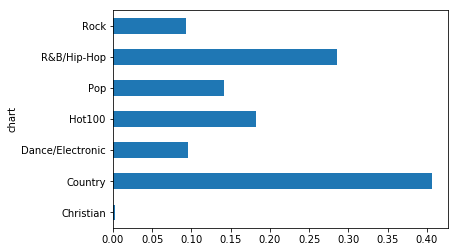

In [76]:
drinkingByChart = (chartsDf.groupby(['chart'])['hasDrinkingWords'].sum() /
                   chartsDf.groupby(['chart']).lyrics.count())
print(drinkingByChart)
drinkingByChart.plot(kind='barh')

### Percentage Songs Mentioning Drinking by Chart and Year

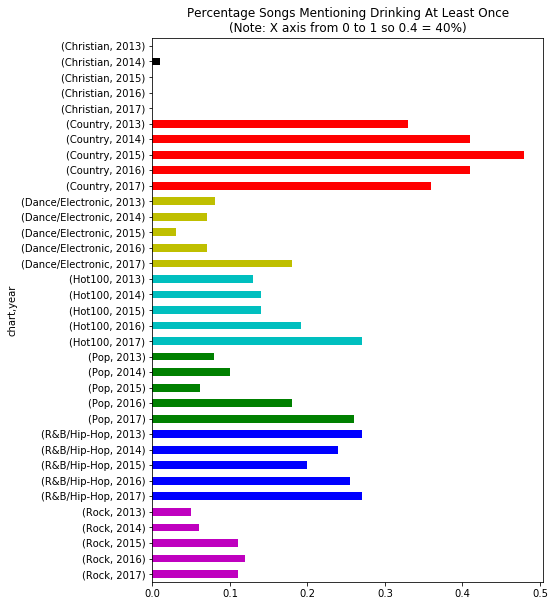

In [77]:
chartTitle = ('Percentage Songs Mentioning Drinking At Least Once' +
              '\n(Note: X axis from 0 to 1 so 0.4 = 40%)')

#the .iloc[::-1] reverses the order of the df and is just cause the 
#years weren't showing up in the right order
drinkingSongsSummary.iloc[::-1].\
percentageOfSongsWithDrinking.plot(kind='barh',
                                   figsize=(7, 10), 
                                   title=chartTitle,
                                   color='mmmmmbbbbbgggggcccccyyyyyrrrrrkkkkk').\
                            get_figure().savefig("percentage_of_drinking_by_chart.png", bbox_inches='tight') 
                            #bbox_inches stops sides of graph getting cut off when saved

### Country Music Vs The Rest

In [78]:
mainGenres = chartsDf[((chartsDf['chart']!='Christian') & (chartsDf['chart']!='Hot100'))]
mainGenres.chart.value_counts()

Rock                500
Country             500
Dance/Electronic    499
R&B/Hip-Hop         423
Pop                 249
Name: chart, dtype: int64

Combined Rock, Pop, R&B/Hip-Hop and Dance/Electronic    0.148291
Country                                                 0.406122
Name: percentageOfSongsWithDrinking, dtype: float64


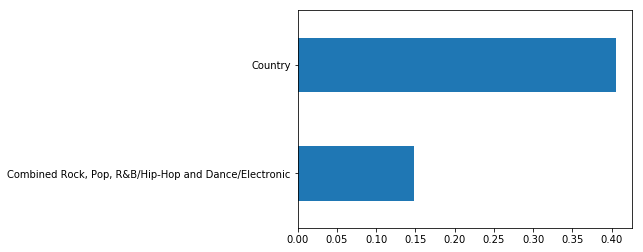

In [80]:
countryRows = ['Country' if i else 'Combined Rock, Pop, R&B/Hip-Hop and Dance/Electronic' 
               for i in mainGenres['chart']=='Country']

countryVsOtherMainGenres = (mainGenres.groupby(countryRows)['hasDrinkingWords'].sum() /
                            mainGenres.groupby(countryRows).lyrics.count())
countryVsOtherMainGenres.name = 'percentageOfSongsWithDrinking'

print(countryVsOtherMainGenres)
countryVsOtherMainGenres.plot(kind='barh')

### Hypothesis Test if Country is Significantly Different From The Other Charts

- Using a significance level of 0.05
- The null hypothesis is that country music doesn't have more songs that mention drinking than other charts
- Inputs are counts of songs that do or don't mention drinking at least once (as opposed to total counts of drinking words)

In [81]:
drinkingTrueCount = mainGenres.groupby(countryRows)['hasDrinkingWords'].sum()
drinkingTrueCount.name = 'drinkingTrueCount'

drinkingFalseCount = (mainGenres.groupby(countryRows).lyrics.count() -
                      mainGenres.groupby(countryRows)['hasDrinkingWords'].sum())
drinkingFalseCount.name = 'drinkingFalseCount'

countryVsOtherMainGenresTrueFalseCounts = pd.concat([drinkingTrueCount, 
                                             drinkingFalseCount], 
                                            axis=1)

countryVsOtherMainGenresTrueFalseCounts

,drinkingTrueCount,drinkingFalseCount
"Combined Rock, Pop, R&B/Hip-Hop and Dance/Electronic",230.0,1321.0
Country,199.0,291.0


In [83]:
#using correction=False so Yate's correction isn't used as none of the 
#expected table values are below 5
chi, p, dof, mu = stats.chi2_contingency(countryVsOtherMainGenresTrueFalseCounts, 
                                         correction=False)
print("chi: ", chi)
print("p:   ", p)
print("dof: ", dof)
print("expected values: \n", mu)

chi:  149.107297924
p:    2.71698301e-34
dof:  1
expected values: 
 [[  326.00636943  1224.99363057]
 [  102.99363057   387.00636943]]


P is way below our significance level of 0.05 so the null hypothesis can be rejected. 

It can therefore be said that **more country music songs mention drinking than other genres**.

This was never really in doubt as the percentage of songs that mention drinking in the other charts is 14% whereas country is nearly 3x as many at 40%. Always to confirm things mathematically though.

### Percentage Songs Mentioning Drinking by Year

Increasing trend

year
2013    0.160428
2014    0.162521
2015    0.173196
2016    0.198594
2017    0.212219
dtype: float64


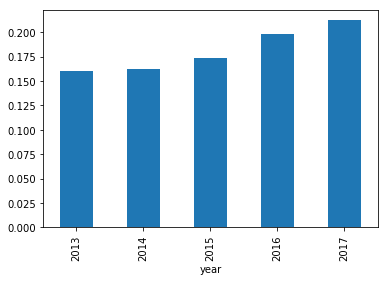

In [85]:
drinkingByYear = (chartsDf.groupby(['year'])['hasDrinkingWords'].sum() / \
                  chartsDf.groupby(['year']).lyrics.count())
print(drinkingByYear)

drinkingByYear.plot(kind='bar')

# Other Fun Drinking Facts

### What people are drinking in different genres

           Country  Dance/Electronic  Pop  R&B/Hip-Hop  Rock
beer            93                 0    0            0     2
bourbon          4                 0    0            0     0
champagne        5                 6    8           21    14
gin              3                 2    4            2     0
moonshine        8                 0    1            1     0
rum             11                 7    2            0     0
scotch           1                 0    0            0     0
tequila          4                 1    3            2     0
vodka            1                 1    1            4     0
whiskey        132                10    8            1     6
wine            56                31    8           11    20


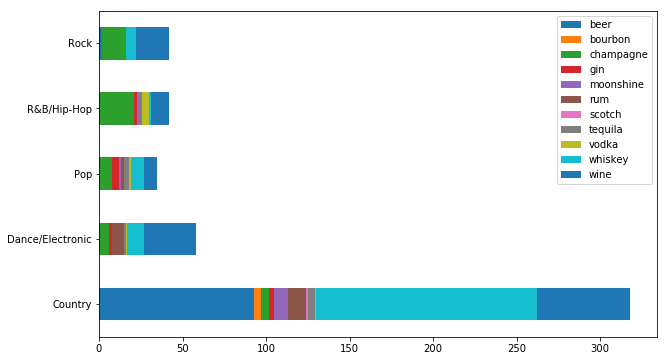

In [88]:
#drink types with > 1 mention used.
drinkTypesDict = {'beer':0, 
                  'whiskey':0, 
                  'tequila':0, 
                  'vodka':0, 
                  'wine':0, 
                  'rum':0, 
                  'moonshine':0,
                  'gin':0,
                  'champagne': 0,
                  'bourbon':0,
                  'scotch': 0                  
                 }

drinkTypesDf = pd.DataFrame({'Country':drinkTypesDict,
                             'Rock':drinkTypesDict,
                             'Pop':drinkTypesDict,
                             'Dance/Electronic':drinkTypesDict,
                             'R&B/Hip-Hop':drinkTypesDict})
def countDrinkTypes(row):
    try:
        if pd.isnull(row.lemmasAndTags): #causes an ValueError when lines is an array (eg [[x], [y]])
            return
    except ValueError:
        pass
    
    for lemmaAndTag in row.lemmasAndTags:
        #lemmaAndTag is tuple in form (lemma, tag) so first item is the lemma
        if lemmaAndTag[0] in drinkTypesDict.keys() and row.chart in drinkTypesDf.columns:
            drinkTypesDf.loc[lemmaAndTag[0], row.chart] = drinkTypesDf.loc[lemmaAndTag[0], row.chart] + 1
    return

chartsDf.apply(countDrinkTypes, axis=1)

drinkTypesDf.to_csv('drink_types_by_genre.csv', 
                    index=True, 
                    encoding='utf-8')

print(drinkTypesDf)
drinkTypesDf.transpose().plot(kind='barh', stacked=True, figsize=(10, 6))

### Boozy-ist Song

In [89]:
maxDrinkingWordsInSong = chartsDf[chartsDf['drinkingWordsCount'] == chartsDf['drinkingWordsCount'].max()]
print('Song:', maxDrinkingWordsInSong.song.values[0])
print('Artist:', maxDrinkingWordsInSong.artist.values[0]) 
print('Drinking words mentions:', maxDrinkingWordsInSong.drinkingWordsCount.values[0]) 
print('Chart:', maxDrinkingWordsInSong.chart.values[0])
print('Year:', maxDrinkingWordsInSong.year.values[0])

Song: Hangover
Artist: PSY Featuring Snoop Dogg
Drinking words mentions: 154.0
Chart: Dance/Electronic
Year: 2014


### Boozy-ist Song by Genre

In [90]:
maxDrinkingWordsInSongByChart = chartsDf.groupby('chart')['drinkingWordsCount'].max()

def getMaxDrinkingSongByChart(row):
    if maxDrinkingWordsInSongByChart[row.chart] == row.drinkingWordsCount:
        print(row.chart, row.year, ':', row.artist, '-', row.song)
        print('Drinking words count:', row.drinkingWordsCount, '\n')
    return

variableJustToStopNonesBeingPrintedOut = chartsDf.apply(getMaxDrinkingSongByChart, axis=1)

Hot100 2013 : Kendrick Lamar - Swimming Pools (Drank)
Drinking words count: 50.0 

R&B/Hip-Hop 2013 : Kendrick Lamar - Swimming Pools (Drank)
Drinking words count: 50.0 

Country 2014 : Dierks Bentley - Drunk On A Plane
Drinking words count: 14.0 

Dance/Electronic 2014 : PSY Featuring Snoop Dogg - Hangover
Drinking words count: 154.0 

Christian 2014 : Lecrae Featuring Andy Mineo - Say I Won't
Drinking words count: 2.0 

Rock 2015 : Panic! At The Disco - Victorious
Drinking words count: 8.0 

Country 2015 : Chris Stapleton - Tennessee Whiskey
Drinking words count: 14.0 

Rock 2016 : Panic! At The Disco - Victorious
Drinking words count: 8.0 

Country 2016 : Brett Eldredge - Drunk On Your Love
Drinking words count: 14.0 

Country 2016 : Chris Stapleton - Tennessee Whiskey
Drinking words count: 14.0 

Country 2017 : Chris Stapleton - Tennessee Whiskey
Drinking words count: 14.0 

Pop 2017 : Kygo & Selena Gomez - It Ain't Me
Drinking words count: 10.0 



# Investigate Most Common Words - Unfinished

Below I find the most common lemmas by chart. It was a bit disappointing as for nearly all charts and word types the most common words are very common ones and don't show much differentiation. I had hoped this would be avoided by removing the stopwords but turns out there's plenty of common words that aren't stopwords.

The only noteworthy exception to this I noticed is that the 3rd 4th and 5th most common nouns are 'bitch', 'nigga' and 'girl' in R&B/Hip-Hop, and 'heart', 'life' and 'god' in the Christian chart respectively. That really highlights a different subject matter between those genres but unfortunatly there isn't many comparisons like that to make.

This analysis in future could be improved by, instead of using simple counts, using a method that highlights the more unique words like TF-IDF.

In [91]:
def countLemmas(row):
    
    #make sure lemmas were found for this song
    #lemmasAndTags will be np.nan if none were found
    try:
        if pd.isnull(row.lemmasAndTags):
            return
    except ValueError:
        pass
    
    for lemmaAndTag in row.lemmasAndTags:
        #add entry to dict with starting values
        if lemmaAndTag not in lemmaCounts.keys():
            lemmaCounts[lemmaAndTag] = {'allChartsCount': 0}
            
            #add counters for each chart (eg hot100, rock, etc)
            for chart in chartsDf.chart.unique():
                lemmaCounts[lemmaAndTag][chart] = 0

        lemmaCounts[lemmaAndTag]['allChartsCount'] = \
        lemmaCounts[lemmaAndTag]['allChartsCount'] + 1

        lemmaCounts[lemmaAndTag][row.chart] = \
        lemmaCounts[lemmaAndTag][row.chart] + 1
        
    return

In [92]:
lemmaCounts = {}
chartsDf.apply(countLemmas, axis=1)

#stop hundreds of Nones being printed out
clear_output()

In [93]:
lemmaCountsDf = pd.DataFrame.from_dict(lemmaCounts, orient='index')

#currently the index of the df is the words and the counts are in a column called 0
lemmaCountsDf.sort_values(by=['allChartsCount'], ascending=False, inplace=True)

#create an actual index and move the lemmas and their tags into columns
lemmaCountsDf.reset_index(inplace=True)

#change the index from starting at 0 to start at 1 so it's easier to see the rank of the rows
lemmaCountsDf.index = lemmaCountsDf.index + 1

lemmaCountsDf.rename(columns={'level_0':'lemma', 'level_1':'wordType'}, inplace=True)


#add the source words for reference
unzippedLemmaSourceWords = list(zip(*lemmaSourceWords.keys()))
lemmasOnly = unzippedLemmaSourceWords[0] #'*' gives inverse zip which splits tuples into two lists
tagsOnly = unzippedLemmaSourceWords[1]
sourceWordsOnly = list(lemmaSourceWords.values())

sourceWordsDf = pd.DataFrame({'lemma':lemmasOnly,
                              'wordType':tagsOnly,
                              'sourceWords':sourceWordsOnly})

sourceWordsDf.set_index(['lemma', 'wordType'], inplace=True)

lemmaCountsDf = lemmaCountsDf.join(sourceWordsDf, on=['lemma', 'wordType'])
lemmaCountsDf.head(15)

,lemma,wordType,allChartsCount,Hot100,Rock,Country,R&B/Hip-Hop,Dance/Electronic,Pop,Christian,sourceWords
1,get,v,12509,2654,1184,2070,3417,1531,1175,478,"[got, get, getting, gets, gotten]"
2,know,v,8474,1867,999,982,1985,1027,926,688,"[know, knows, knew, known, knowing]"
3,like,n,8001,1640,839,1308,2073,896,743,502,"[like, likes]"
4,go,v,7700,1541,1178,1213,1340,1119,721,588,"[go, going, gone, goes, gon, went]"
5,want,v,5525,1209,664,882,1047,761,637,325,"[want, wan, wanted, wanting, wants]"
6,yeah,n,4881,1151,387,751,1468,472,476,176,[yeah]
7,make,v,4316,757,502,753,844,572,397,491,"[make, makes, making, made]"
8,let,v,4223,869,525,504,556,832,507,430,"[let, letting, lets]"
9,say,v,4121,882,619,536,897,457,397,333,"[say, said, saying, says]"
10,take,v,3973,639,820,620,604,510,359,421,"[take, takes, took, taking, taken]"


In [94]:
def topLemmasForAWordTypeByChart(wordType=None):
    if wordType is None:
        df = lemmaCountsDf
    else:
        df = lemmaCountsDf[lemmaCountsDf.wordType == wordType]
        
    concatenatedDf = df.sort_values(by='allChartsCount', 
                                    ascending=False, 
                                    inplace=False)[['lemma']]
    concatenatedDf.rename(columns={'lemma':'allCharts'}, inplace=True)
    concatenatedDf.reset_index(inplace=True, drop=True)

        
    for chart in chartsDf.chart.unique():
        tempDf = df.sort_values(by=[chart], 
                                ascending=False, 
                                inplace=False)[['lemma']]

        tempDf.rename(columns={'lemma':chart}, inplace=True)
        tempDf.reset_index(inplace=True, drop=True)

        concatenatedDf = pd.concat([concatenatedDf, tempDf], axis=1)
    
    #reset index to start from 1
    concatenatedDf.index = concatenatedDf.index + 1
    
    return concatenatedDf


In [95]:
topAllWordTypesDf = topLemmasForAWordTypeByChart()
topAllWordTypesDf.head(15)

,allCharts,Hot100,Rock,Country,R&B/Hip-Hop,Dance/Electronic,Pop,Christian
1,get,get,get,get,get,get,get,know
2,know,know,go,like,like,go,know,go
3,like,like,know,go,know,know,like,love
4,go,go,like,know,yeah,like,go,like
5,want,want,take,want,go,let,want,make
6,yeah,yeah,want,make,bitch,love,let,get
7,make,say,say,yeah,nigga,want,love,see
8,let,let,love,girl,want,come,yeah,come
9,say,love,come,little,say,feel,come,heart
10,take,baby,time,baby,make,make,make,life


In [96]:
#df called NounsAndOther as everything that's not an adjective, verb
#or adverb gets lumped in with nouns
topNounsAndOthersDf = topLemmasForAWordTypeByChart('n')
topNounsAndOthersDf.head(15)

,allCharts,Hot100,Rock,Country,R&B/Hip-Hop,Dance/Electronic,Pop,Christian
1,like,like,like,like,like,like,like,love
2,yeah,yeah,time,yeah,yeah,love,yeah,like
3,love,baby,cause,girl,bitch,way,baby,heart
4,one,cause,love,baby,nigga,night,cause,life
5,baby,one,one,night,girl,yeah,one,god
6,time,love,yeah,one,baby,cause,love,one
7,cause,time,way,time,one,one,time,every
8,way,girl,life,way,cause,baby,night,name
9,girl,night,heart,every,man,time,girl,time
10,night,way,could,go,time,heart,heart,way


In [97]:
topVerbsDf = topLemmasForAWordTypeByChart('v')
topVerbsDf.head(15)

,allCharts,Hot100,Rock,Country,R&B/Hip-Hop,Dance/Electronic,Pop,Christian
1,get,get,get,get,get,get,get,know
2,know,know,go,go,know,go,know,go
3,go,go,know,know,go,know,go,make
4,want,want,take,want,want,let,want,get
5,make,say,want,make,say,want,let,see
6,let,let,say,take,make,come,love,come
7,say,love,love,say,love,feel,make,let
8,take,make,come,let,tell,make,say,take
9,love,come,let,love,take,love,come,say
10,come,take,make,come,come,take,take,want


In [98]:
topAdjectivesDf = topLemmasForAWordTypeByChart('a')
topAdjectivesDf.head(15)

,allCharts,Hot100,Rock,Country,R&B/Hip-Hop,Dance/Electronic,Pop,Christian
1,good,good,little,little,good,low,good,good
2,little,low,good,good,real,good,low,alive
3,high,little,high,old,bad,high,old,beautiful
4,low,bad,much,high,new,deep,little,great
5,real,high,free,long,high,bubble,bad,high
6,bad,real,hard,red,nigga,little,real,new
7,old,young,right,last,young,hard,cold,open
8,new,old,black,right,big,right,hard,deep
9,young,new,last,crazy,little,real,high,strong
10,right,big,young,blue,much,bad,ready,free


In [99]:
topAdverbsDf = topLemmasForAWordTypeByChart('r')
topAdverbsDf.head(15)

,allCharts,Hot100,Rock,Country,R&B/Hip-Hop,Dance/Electronic,Pop,Christian
1,never,never,back,back,never,never,never,never
2,back,back,never,never,back,back,back,back
3,away,ever,away,right,even,away,still,away
4,still,still,well,ever,still,right,ever,ever
5,ever,even,still,away,really,ever,even,alone
6,right,away,even,well,right,alone,right,still
7,even,right,ever,still,ever,well,away,right
8,well,really,alone,even,well,always,well,always
9,always,well,always,always,always,long,really,even
10,really,always,right,long,yeah,still,always,far
